In sintesi:
* escluse feature con correlazione > 0.9
* esclusa macchina 'difettosa'
* cross validation con shuffle
* modelli a 3 layer, ho tolto il dropout
* solita questione della riproducibilità dei risultati

## Preprocessing

In [1]:
%%capture
# deal with randomness
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(0)
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(0)
# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(0)
# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(0)

# clone repository
!git clone https://github.com/michelevece/industry

#install and import libraries
!pip install py7zr #&> dev\null
import os
import py7zr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
sys.path.append('/content/industry')
from util import cmapss

# extract data from repository
path = '/content/industry'
filename = "dataset_jan_may(4).7z"

with py7zr.SevenZipFile(f"{path}/{filename}", mode='r') as z:
    z.extractall(path)

### Reading the data
Data is read and a code wrt the dataframe itself and the machine is associated to each dataframe

In [2]:
dfs = [] #list containing the dataframes
for folder, subfolders, files in os.walk(f"{path}/datasets") :
    for f in files:
        #print(f"Reading file: {f}")
        dfs.append(pd.read_csv(f"{folder}/{f}", index_col=0))

# keep track of dataframe number and machine number for each df
for i, df in enumerate(dfs):
    df['machine'] = math.floor(i/2)
    df['dataframe'] = i

print(f'There are {(len(dfs))/2} machines')    

There are 20.0 machines


### RUL computation
Compute RULs for each row of the dataframes.
The RUL value is obtained as the difference between the index of the row containing the next failure and the index of the current row.

In some cases RULs cannot be computed because there's no failure in the next rows. In such cases, RULs are left equal to -1

In [3]:
for df in dfs:
    #in this way, failure rows have rul=0, non-failure rows have rul=-1
    df['rul'] = df.label - 1
    #indices of rows containing a failure
    failure_idx = df[df['rul'] == 0].index.tolist()
    #preprend a row with index=-1 as failure (it's just an artifact) 
    failure_idx.insert(0, -1) 

    #compute ruls for each row
    for i in (range(len(failure_idx)-1)):
        #indices of rows between two failures
        idx = df[(df.index > failure_idx[i]) & (df.index < failure_idx[i+1])].index
        #compute ruls as difference between next failure and current row index
        df.loc[idx, 'rul'] = [failure_idx[i+1] - current_idx for current_idx in idx.tolist()]


In [4]:
def plot_ruls(d):
    # plot ruls for all the dataframes
    fig, axes = plt.subplots(5,8, figsize=(32, 20))

    for i in range(5):
        for j in range(8):
            tmp = d[i*8+j]
            axes[i,j].plot(tmp.rul[tmp.rul>0], 'b', label='RUL')
            axes[i,j].plot(tmp.rul[tmp.rul<0], ':g', label='RUL not computed')
            axes[i,j].plot(tmp.rul[tmp.rul==0], '.r', label='Failure')

    lines, labels = fig.axes[-1].get_legend_handles_labels()    
    fig.legend(lines, labels)
    plt.suptitle('RULs for each dataframe')

    plt.show()

#plot_ruls(dfs)

### Further preprocessing

The following is applied:

* *Label* column is removed
* Rows with **rul=-1** are removed
* For each failure, only the first row is kept. So, consecutive rows having **rul=0** are removed
* After rows removal, index is reset.

Then, the different dataframes are concatenated in order to  obtain a single, larger dataframe



In [5]:
data = list()

for df in dfs:
    # remove 'label' column and row with negative rul
    idx = df[df.rul>=0].index
    d = df.copy().drop(columns=['label']).loc[idx]
    # convert timestamp to integer
    d.timestamp = d.index.tolist()
    # remove consecutive rows having same rul
    # nb it's a way to remove consecutive rows with rul = 0
    d = d[d.rul!= d.shift(1).rul]
    # reset index
    d = d.reset_index(drop=True)

    #print(df.shape[0]==d.shape0)
    data.append(d)

In [6]:
#plot_ruls(data)

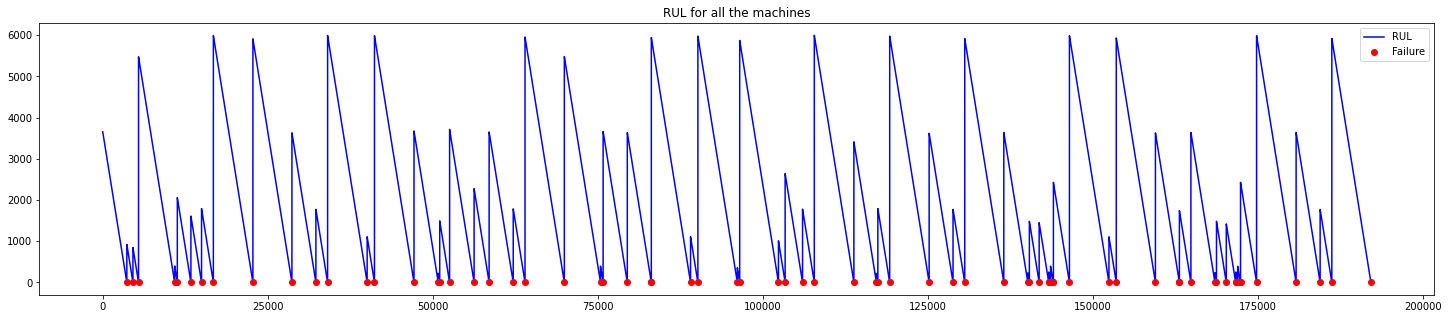

In [7]:
# concatenate all data
dt = pd.concat(data, ignore_index=True)
# remove consecutive rows with rul = 0
dt = dt[dt.rul!= dt.shift(1).rul]
# reset index
dt = dt.reset_index(drop=True)

plt.figure(figsize=(25,5))
plt.plot(dt.rul[dt.rul>0], 'b', label='RUL')
plt.plot(dt.rul[dt.rul==0], 'or', label='Failure')
plt.title('RUL for all the machines')
plt.legend()

### Run-to-failure experiments
Here, we compute how many **run-to-failure experiments** there exist and associate each row to its corresponding experiment.

In order to do that:
* First, for each failure, we compute its row index. 
* Then, we associate a different code for rows between two different failures

Experiments whose length is less than 5 are removed.

In [8]:
# define single run-to-failure experiments
failure_idx = dt[dt.rul==0].index.tolist()
#preprend a failure with index=-1 (it's just an artifact)
failure_idx.insert(0, -1)

for i in range(len(failure_idx)-1):
    start = failure_idx[i]+1
    end = failure_idx[i+1]+1
    idx = dt[start:end].index
    #associate NaN value to experiments whose length < threshold
    if (end - start) <= 5:
        dt.loc[idx, 'experiment'] = np.NaN
    else:
        dt.loc[idx, 'experiment'] = i
        
# remove experiments whose max rul < 5
dt.dropna(inplace=True)

print(f'There are {len(dt.machine.unique())} machines')
print(f'There are {len(dt.dataframe.unique())} dataframes')
print(f'There are {len(dt.experiment.unique())} run-to-fail experiments')

There are 20 machines
There are 37 dataframes
There are 71 run-to-fail experiments


Text(0.5, 1.0, 'Length of run-to-failure experiment (decreasing order)')

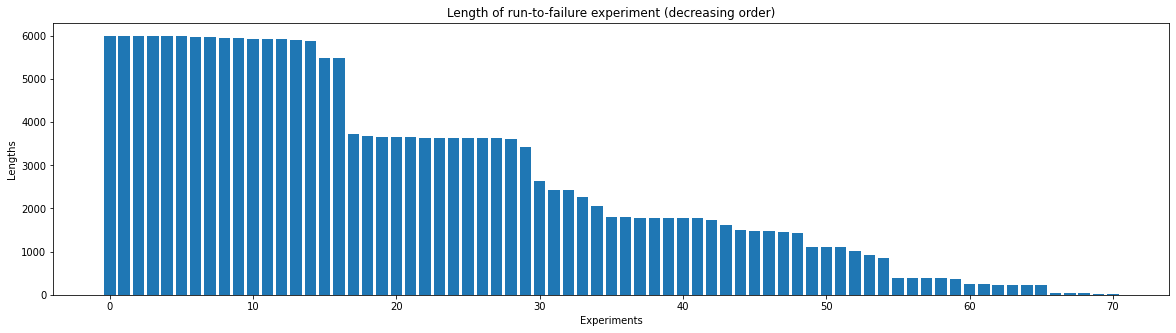

In [9]:
plt.figure(figsize=(20,5))
plt.bar(range(len(dt.experiment.unique())), dt.experiment.value_counts())
plt.xlabel('Experiments')
plt.ylabel('Lengths')
plt.title('Length of run-to-failure experiment (decreasing order)')

We can observe that:
* experiments have very different lengths
* there are some experiments whose lenght is very short: in these experiments the machine breaks after a few cycles

Text(0, 0.5, 'Number of observations')

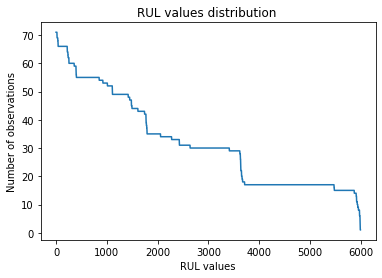

In [10]:
# From another viewpoint
plt.plot(dt.rul.value_counts().values)
plt.title('RUL values distribution ')
plt.xlabel('RUL values')
plt.ylabel('Number of observations')

In [11]:
#dt.experiment.value_counts().describe()

### Feature and experiment selection


The following is applied:
* feature that are always constant are removed (critierion: std = 0) 
* experiment having lots of features (eg. > 20) with constant values are removed (we supposed values may be missing/invalid)
* features that are almost always constant are removed (criterion: std < 0.1)
* features constant but having just fews abnormal peaks are removed (criterion: the mode represents > 99% of the values) 

Then, correlated features are moved (criterion: correlation index > 0.9)

In [12]:
dt2 = dt.copy()

# check if there are NaN values in the data
print(dt2.isna().any().any())
print(f'Initially, there are {len(dt2.columns)} features')

#remove constant attributes
features = dt2.columns[1:-4]
constant_features = features[dt2[features].std()==0].tolist()
dt2.drop(columns=constant_features, inplace=True)
print(f'After removing constant features, there are {len(dt2.columns)} features')

#remove experiments which have constant values for at least 20 features
tmp_idx = (dt2.groupby('experiment').std()==0).sum(axis=1)>20
exp_to_del = dt2.experiment.unique()[tmp_idx]
dt2.drop(dt2.loc[dt.experiment.isin(exp_to_del)].index, inplace=True)
dt2.reset_index(drop=True, inplace=True)
print(f'{len(exp_to_del)} experiments have been removed')

dt2.reset_index(drop=True, inplace=True)

#remove almost constant attributes with few peaks
m, n = dt2.shape
features = dt2.columns[1:-4]
anomalies = [f for f in features if (dt2[f].isin(dt2[f].mode())).sum()>0.99*m]
dt2.drop(columns=anomalies, inplace=True)
print(f'After removing features containing abnormal values, there are {len(dt2.columns)} features')

#remove almost constant features
features = dt2.columns[1:-4]
almost_constant_features = features[dt2[features].std()<0.01].tolist()
dt2.drop(columns=almost_constant_features, inplace=True)
print(f'After removing almost constant features, there are {len(dt2.columns)} features')

False
Initially, there are 126 features
After removing constant features, there are 112 features
10 experiments have been removed
After removing features containing abnormal values, there are 105 features
After removing almost constant features, there are 103 features


In [13]:
def compute_correlation(cols, thr):
    # compute correlation matrix
    corr_matrix = dt2[cols].corr()
    m,n = corr_matrix.shape
    # compute correlated features
    corr_features = set()
    for i in range(m-1):
        for j in range(i+1, n):
            if (corr_matrix.columns[i] not in corr_features) and (abs(corr_matrix.iloc[i,j])>thr):
                corr_features.add(corr_matrix.columns[j])
    return corr_features

# delete correlated features
corr_features = compute_correlation(dt2.columns[1:-4], 0.9)
print(f"There are {len(corr_features)} correlated features")
dt2.drop(columns=corr_features, inplace=True)

There are 39 correlated features


In [14]:
print(f'There are {len(dt2.machine.unique())} machines')
print(f'There are {len(dt2.dataframe.unique())} dataframes')
print(f'There are {len(dt2.experiment.unique())} run-to-fail experiments')
print(f"There are {len(dt2.columns[1:-4])} features")

There are 19 machines
There are 35 dataframes
There are 61 run-to-fail experiments
There are 59 features


## Train, Test, Standardization, Normalization

* Data is split according to run-to-failure experiment, so that data referring to the same experiment is kept together, but the same dataframe/machine may appear both in training and test data

* Data is standardized, rul values are mapped in range [0, 1]

* Outliers values are mapped to mean - 3 * std (or mean + 3 * std) 


In [15]:
from sklearn.model_selection import train_test_split

tr_split, ts_split = train_test_split(dt2.experiment.unique(), test_size=0.2, 
                                      shuffle=True, random_state=42)
tr_idx = dt2[dt2.experiment.isin(tr_split)].index
ts_idx = dt2[dt2.experiment.isin(ts_split)].index
tr = dt2.loc[tr_idx]
ts = dt2.loc[ts_idx]

#all columns except 'timestamp', 'rul', 'dataframe', 'machine', 'experiment'
dt_in = dt2.columns[1:-4]

tr = tr.reset_index(drop=True)
ts = ts.reset_index(drop=True)

#compute train, test
tr_mean = tr[dt_in].mean()
tr_dev = tr[dt_in].std().replace(to_replace=0, value=1)

tr_s = tr.copy()
ts_s = ts.copy()

tr_s[dt_in] = (tr[dt_in] - tr_mean) / tr_dev
ts_s[dt_in] = (ts[dt_in] - tr_mean) / tr_dev

tr_maxrul = tr.rul.max()

tr_s.rul = tr.rul / tr_maxrul 
ts_s.rul = ts.rul / tr_maxrul 

In [16]:
for f in dt_in:
    tr_s.loc[tr_s[f]> 3, f] =  3
    tr_s.loc[tr_s[f]<-3, f] = -3
    ts_s.loc[ts_s[f]> 3, f] =  3
    ts_s.loc[ts_s[f]<-3, f] = -3

# Implementation

In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold

#cross fold validation and early stopping
kfold = KFold(n_splits=5) 
cb = [EarlyStopping(patience=7, restore_best_weights=True)]

def plot_kfold_history(history):
    loss=[]
    val_loss=[]
    for h in history:
        loss.extend(h.history['loss'])
        val_loss.extend(h.history['val_loss'])
    plt.plot(loss, label= 'loss')
    plt.plot(val_loss, label= 'val_loss')
    plt.legend()

In [18]:
failtimes = dt2.groupby('experiment').rul.max()
safe_interval = failtimes.min()
failure_cost = failtimes.max()

print(failtimes.describe())

cmodel = cmapss.RULCostModel(failure_cost, safe_interval)

# method to print cost, fail, slack for both training and test set
def print_cfs(tr_pred, ts_pred, tr_thr):
    cost, fails, slack = cmodel.cost(tr.experiment.values, tr_pred, tr_thr, return_margin=True)
    
    print('On training set:')
    print(f"Cost: {cost} \t Avg fails: {fails/len(tr.experiment.unique()):.2f} Avg slack: {slack/len(tr.experiment.unique()):.2f}")
    
    print('\nOn test set:')
    cost, fails, slack = cmodel.cost(ts.experiment.values, ts_pred, tr_thr, return_margin=True)
    print(f"Cost: {cost} \t Avg fails: {fails/len(ts.experiment.unique()):.2f} Avg slack: {slack/len(ts.experiment.unique()):.2f}")

count      61.000000
mean     2968.639344
std      2046.027395
min        33.000000
25%      1449.000000
50%      2427.000000
75%      5475.000000
max      5996.000000
Name: rul, dtype: float64


## Model 1: Regression

In [19]:
def build_regressor():
    model_in = layers.Input(shape=(len(dt_in,)))
    x = layers.Dense(12, activation='relu')(model_in)
    x = layers.Dropout(0.4, seed=0)(x)
    x = layers.Dense(6, activation='relu')(x)
    x = layers.Dropout(0.2, seed=0)(x)
    model_out = layers.Dense(1, activation='linear')(x)
    model = Model(model_in, model_out)
    return model

nn1 = build_regressor()
nn1.compile(optimizer='adam', loss='mse')
nn1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 59)]              0         
_________________________________________________________________
dense (Dense)                (None, 12)                720       
_________________________________________________________________
dropout (Dropout)            (None, 12)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 78        
_________________________________________________________________
dropout_1 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 7         
Total params: 805
Trainable params: 805
Non-trainable params: 0
_______________________________________________________________

In [20]:
history1 = []

for train, val in kfold.split(tr_s[dt_in], tr_s.rul):
    x_tr, y_tr = tr_s.loc[train, dt_in], tr_s.loc[train, 'rul']
    x_val, y_val = tr_s.loc[val, dt_in], tr_s.loc[val, 'rul']
    history = nn1.fit(x_tr, y_tr, validation_data=(x_val, y_val), epochs=20, callbacks=cb)
    history1.append(history)

Epoch 1/20
3468/3468 [==============================] - 6s 2ms/step - loss: 0.1991 - val_loss: 0.0604
Epoch 2/20
3468/3468 [==============================] - 5s 1ms/step - loss: 0.0440 - val_loss: 0.0650
Epoch 3/20
3468/3468 [==============================] - 5s 1ms/step - loss: 0.0355 - val_loss: 0.0487
Epoch 4/20
3468/3468 [==============================] - 5s 1ms/step - loss: 0.0324 - val_loss: 0.0373
Epoch 5/20
3468/3468 [==============================] - 5s 1ms/step - loss: 0.0310 - val_loss: 0.0371
Epoch 6/20
3468/3468 [==============================] - 5s 1ms/step - loss: 0.0279 - val_loss: 0.0367
Epoch 7/20
3468/3468 [==============================] - 5s 1ms/step - loss: 0.0268 - val_loss: 0.0337
Epoch 8/20
3468/3468 [==============================] - 5s 1ms/step - loss: 0.0264 - val_loss: 0.0365
Epoch 9/20
3468/3468 [==============================] - 5s 1ms/step - loss: 0.0259 - val_loss: 0.0320
Epoch 10/20
3468/3468 [==============================] - 5s 1ms/step - loss: 0.026

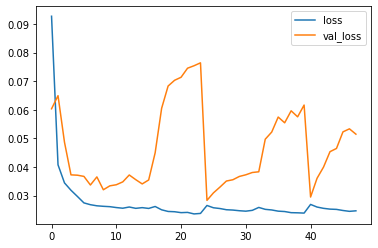

In [21]:
plot_kfold_history(history1)

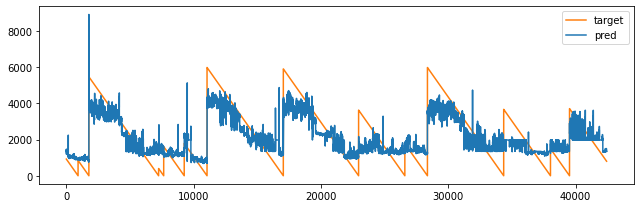

In [72]:
stop=len(ts)
tr_pred1 = nn1.predict(tr_s[dt_in]).ravel()*tr_maxrul
cmapss.plot_rul(tr_pred1[:stop], tr.rul[:stop])

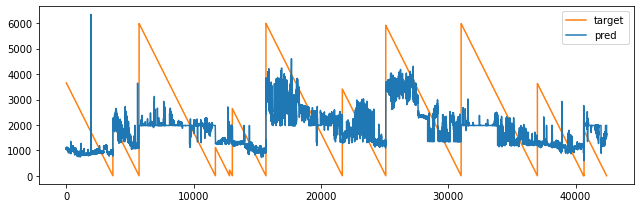

In [23]:
ts_pred1 = nn1.predict(ts_s[dt_in]).ravel()*tr_maxrul
cmapss.plot_rul(ts_pred1[:], ts.rul[:])

### Evaluation (1): loss

In [24]:
nn1.evaluate(tr_s[dt_in], tr_s.rul)

4335/4335 [==============================] - 6s 1ms/step - loss: 0.0227


0.02270539663732052

In [25]:
nn1.evaluate(ts_s[dt_in], ts_s.rul)

1326/1326 [==============================] - 2s 1ms/step - loss: 0.0590


0.05903932452201843

### Evaluation (2): Cost Model

Optimal threshold: 1500


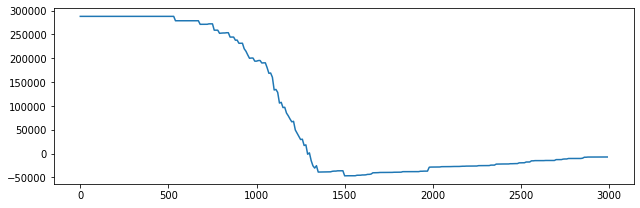

In [26]:
thr_range = np.arange(0, 3000, 10)
tr_thr1 = cmapss.opt_threshold_and_plot(tr.experiment.values, tr_pred1, thr_range, cmodel)
print(f'Optimal threshold: {tr_thr1}')

In [27]:
print_cfs(tr_pred1, ts_pred1, tr_thr1)

On training set:
Cost: -46821.0 	 Avg fails: 0.00 Avg slack: 1897.19

On test set:
Cost: -8368.0 	 Avg fails: 0.08 Avg slack: 2143.54


## Model 2: Classification

In [28]:
def build_classifier():
    model_in = layers.Input(len(dt_in))
    x = layers.Dense(12, 'relu')(model_in)
    x = layers.Dropout(0.2, seed=0)(x)
    x = layers.Dense(8, 'relu')(x)
    x = layers.Dropout(0.2, seed=0)(x)
    x = layers.Dense(1, 'sigmoid')(x)
    return Model(model_in, x)

nn2 = build_classifier()
nn2.compile(optimizer='adam', loss='binary_crossentropy')
nn2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 59)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 12)                720       
_________________________________________________________________
dropout_2 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 104       
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 833
Trainable params: 833
Non-trainable params: 0
_____________________________________________________________

In [29]:
class_threshold = 500
tr_lbl = tr.rul >= class_threshold
ts_lbl = ts.rul >= class_threshold 

In [30]:
history2 = []

for train, val in kfold.split(tr_s[dt_in], tr_lbl):
    x_tr, y_tr = tr_s.loc[train, dt_in], tr_lbl.loc[train]
    x_val, y_val = tr_s.loc[val, dt_in], tr_lbl.loc[val]
    history = nn2.fit(x_tr, y_tr, validation_data=(x_val, y_val), epochs=20, callbacks=cb)
    history2.append(history)

Epoch 1/20
3468/3468 [==============================] - 6s 2ms/step - loss: 0.4428 - val_loss: 0.4122
Epoch 2/20
3468/3468 [==============================] - 6s 2ms/step - loss: 0.3225 - val_loss: 0.4920
Epoch 3/20
3468/3468 [==============================] - 5s 1ms/step - loss: 0.2837 - val_loss: 0.5504
Epoch 4/20
3468/3468 [==============================] - 5s 1ms/step - loss: 0.2637 - val_loss: 0.5703
Epoch 5/20
3468/3468 [==============================] - 5s 1ms/step - loss: 0.2550 - val_loss: 0.6585
Epoch 6/20
3468/3468 [==============================] - 5s 1ms/step - loss: 0.2479 - val_loss: 0.6454
Epoch 7/20
3468/3468 [==============================] - 5s 1ms/step - loss: 0.2445 - val_loss: 0.6927
Epoch 8/20
3468/3468 [==============================] - 5s 1ms/step - loss: 0.2362 - val_loss: 0.6941
Epoch 1/20
3468/3468 [==============================] - 5s 1ms/step - loss: 0.3289 - val_loss: 0.4789
Epoch 2/20
3468/3468 [==============================] - 5s 1ms/step - loss: 0.2872

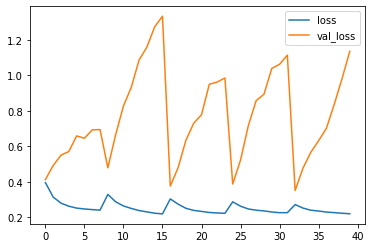

In [31]:
plot_kfold_history(history2)

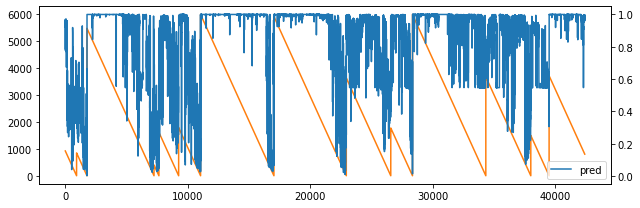

In [73]:
stop=len(ts)
tr_pred2 = nn2.predict(tr_s[dt_in]).ravel()
cmapss.plot_rul(tr_pred2[:stop], tr.rul[:stop], same_scale=False)

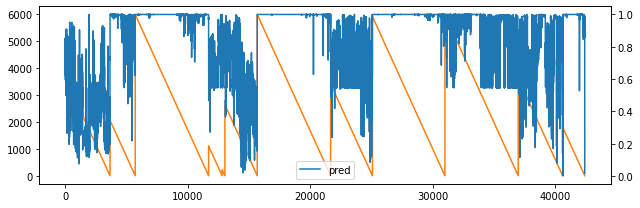

In [74]:
ts_pred2 = nn2.predict(ts_s[dt_in]).ravel()
cmapss.plot_rul(ts_pred2[:], ts.rul[:], same_scale=False)

In [75]:
print_cfs(tr_pred2, ts_pred2, 0.5)

On training set:
Cost: -26384.0 	 Avg fails: 0.12 Avg slack: 1159.58

On test set:
Cost: 34423.0 	 Avg fails: 0.46 Avg slack: 1275.46


##Model 3: Sliding Windows

In [35]:
def sliding_window_by_experiment(data, wlen, cols, stride=1):
    l_w, l_e, l_r = [], [], []
    for mcn, gdata in data.groupby('experiment'):
        # Apply a sliding window
        tmp_w = cmapss.sliding_window_2D(gdata[cols], wlen, stride)
        # Build the experiment vector
        tmp_e = gdata['experiment'].iloc[wlen-1::stride]
        # Build the RUL vector
        tmp_r = gdata['rul'].iloc[wlen-1::stride]
        # Store everything
        l_w.append(tmp_w)
        l_e.append(tmp_e)
        l_r.append(tmp_r)
    res_w = np.concatenate(l_w)
    res_e = np.concatenate(l_e)
    res_r = np.concatenate(l_r)
    return res_w, res_e, res_r


wlen = 3

tr_sw, tr_sw_e, tr_sw_r = sliding_window_by_experiment(tr_s, wlen, dt_in)
ts_sw, ts_sw_e, ts_sw_r = sliding_window_by_experiment(ts_s, wlen, dt_in) 


def build_cnn_regressor(wlen):
    input_shape = (wlen, len(dt_in))
    model_in = layers.Input(shape=input_shape, dtype='float32')
    x = layers.Conv1D(12, kernel_size=3, activation='relu')(model_in)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.4, seed=0)(x)
    x = layers.Dense(6, activation='relu')(x)
    x = layers.Dropout(0.4, seed=0)(x)
    model_out = layers.Dense(1, activation='linear')(x)
    model = Model(model_in, model_out)
    return model

nn3 = build_cnn_regressor(wlen)
nn3.compile(optimizer='adam', loss='mse')
nn3.summary()    

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 3, 59)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1, 12)             2136      
_________________________________________________________________
flatten (Flatten)            (None, 12)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 78        
_________________________________________________________________
dropout_5 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 7   

In [36]:
 history3 = []

for train, val in kfold.split(tr_sw, tr_sw_r):
    x_tr, y_tr = tr_sw[train], tr_sw_r[train]
    x_val, y_val = tr_sw[val], tr_sw_r[val]
    history = nn3.fit(x_tr, y_tr, validation_data=(x_val, y_val), epochs=20, callbacks=cb)
    history3.append(history)

Epoch 1/20
3466/3466 [==============================] - 6s 2ms/step - loss: 0.1316 - val_loss: 0.0726
Epoch 2/20
3466/3466 [==============================] - 5s 1ms/step - loss: 0.0419 - val_loss: 0.0593
Epoch 3/20
3466/3466 [==============================] - 5s 1ms/step - loss: 0.0377 - val_loss: 0.0397
Epoch 4/20
3466/3466 [==============================] - 5s 1ms/step - loss: 0.0347 - val_loss: 0.0323
Epoch 5/20
3466/3466 [==============================] - 5s 1ms/step - loss: 0.0325 - val_loss: 0.0270
Epoch 6/20
3466/3466 [==============================] - 5s 1ms/step - loss: 0.0323 - val_loss: 0.0243
Epoch 7/20
3466/3466 [==============================] - 5s 1ms/step - loss: 0.0316 - val_loss: 0.0258
Epoch 8/20
3466/3466 [==============================] - 5s 1ms/step - loss: 0.0315 - val_loss: 0.0222
Epoch 9/20
3466/3466 [==============================] - 5s 1ms/step - loss: 0.0315 - val_loss: 0.0237
Epoch 10/20
3466/3466 [==============================] - 5s 1ms/step - loss: 0.031

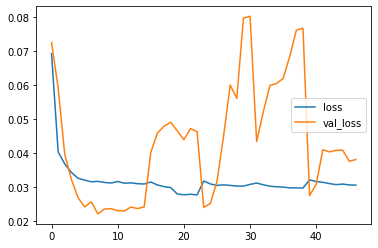

In [37]:
plot_kfold_history(history3)

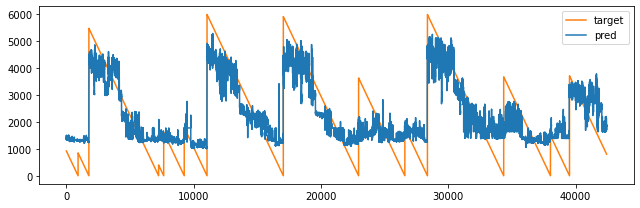

In [76]:
stop=len(ts)
tr_pred3 = nn3.predict(tr_sw).ravel()*tr_maxrul
cmapss.plot_rul(tr_pred3[:stop], tr.rul[:stop])

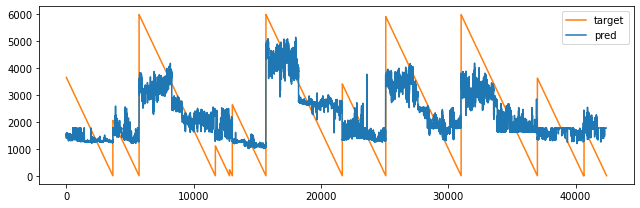

In [77]:
ts_pred3 = nn3.predict(ts_sw).ravel()*tr_maxrul
cmapss.plot_rul(ts_pred3[:], ts.rul[:])

Optimal threshold: 1630


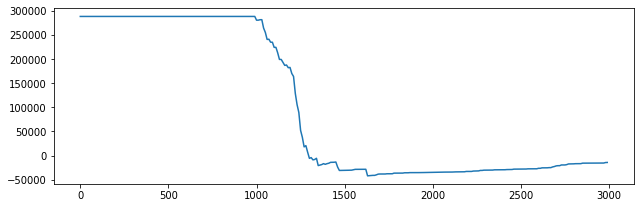

In [40]:
thr_range = np.arange(0, 3000, 10)
tr_thr3 = cmapss.opt_threshold_and_plot(tr_sw_e, tr_pred3, thr_range, cmodel)
print(f'Optimal threshold: {tr_thr3}')

In [68]:
cost, fails, slack = cmodel.cost(tr_sw_e, tr_pred3, tr_thr3, return_margin=True)
print(f"Cost: {cost} \t Avg fails: {fails/len(tr.experiment.unique()):.2f} Avg slack: {slack/len(tr.experiment.unique()):.2f}")

Cost: -41828.0 	 Avg fails: 0.00 Avg slack: 2001.88


In [69]:
cost, fails, slack = cmodel.cost(ts_sw_e, ts_pred3, tr_thr3, return_margin=True)
print(f"Cost: {cost} \t Avg fails: {fails/len(ts.experiment.unique()):.2f} Avg slack: {slack/len(ts.experiment.unique()):.2f}")

Cost: -15532.0 	 Avg fails: 0.00 Avg slack: 2056.15


##Model 4: Same Stop Chance

In [43]:
def build_model4():
    model_in = layers.Input(shape=(len(dt_in,)))
    x = layers.Dense(12, activation='relu')(model_in)
    x = layers.Dropout(0.2, seed=0)(x)
    x = layers.Dense(6, activation='relu')(x)
    x = layers.Dropout(0.2, seed=0)(x)
    model_out = layers.Dense(1, activation='linear')(x)
    model = Model(model_in, model_out)
    return model

nn4 = build_model4()
nn4.compile(loss='mse', optimizer='adam')
nn4.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 59)]              0         
_________________________________________________________________
dense_8 (Dense)              (None, 12)                720       
_________________________________________________________________
dropout_6 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 78        
_________________________________________________________________
dropout_7 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 7         
Total params: 805
Trainable params: 805
Non-trainable params: 0
_____________________________________________________________

In [44]:
history4 = []

for train, val in kfold.split(tr_s[dt_in], tr_s.rul):
    x_tr, y_tr = tr_s.loc[train, dt_in], tr_s.loc[train, 'rul']
    x_val, y_val = tr_s.loc[val, dt_in], tr_s.loc[val, 'rul']
    sample_weight = 1/((1+y_tr.values)**2)
    history = nn4.fit(x_tr, y_tr, validation_data=(x_val, y_val), epochs=20, 
                      callbacks=cb, sample_weight=sample_weight)
    history4.append(history)

Epoch 1/20
3468/3468 [==============================] - 6s 2ms/step - loss: 0.0552 - val_loss: 0.0632
Epoch 2/20
3468/3468 [==============================] - 5s 1ms/step - loss: 0.0167 - val_loss: 0.0332
Epoch 3/20
3468/3468 [==============================] - 5s 1ms/step - loss: 0.0139 - val_loss: 0.0272
Epoch 4/20
3468/3468 [==============================] - 5s 1ms/step - loss: 0.0126 - val_loss: 0.0283
Epoch 5/20
3468/3468 [==============================] - 5s 1ms/step - loss: 0.0120 - val_loss: 0.0250
Epoch 6/20
3468/3468 [==============================] - 5s 1ms/step - loss: 0.0114 - val_loss: 0.0288
Epoch 7/20
3468/3468 [==============================] - 5s 1ms/step - loss: 0.0111 - val_loss: 0.0318
Epoch 8/20
3468/3468 [==============================] - 5s 1ms/step - loss: 0.0108 - val_loss: 0.0324
Epoch 9/20
3468/3468 [==============================] - 5s 1ms/step - loss: 0.0106 - val_loss: 0.0344
Epoch 10/20
3468/3468 [==============================] - 5s 1ms/step - loss: 0.010

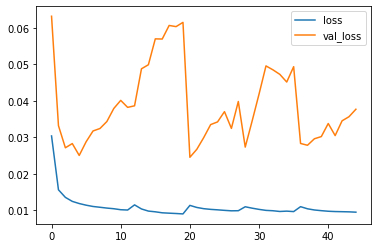

In [45]:
plot_kfold_history(history4)

Text(0.5, 1.0, 'Prediction on training set')

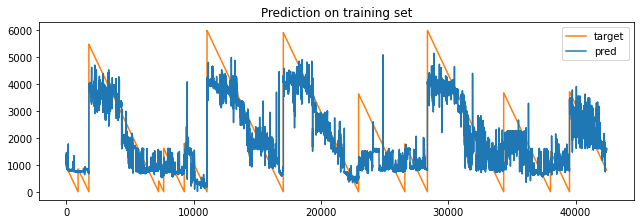

In [78]:
stop=len(ts)
tr_pred4 = nn4.predict(tr_s[dt_in]).ravel()*tr_maxrul
cmapss.plot_rul(tr_pred4[:stop], tr.rul[:stop])
plt.title('Prediction on training set')

Text(0.5, 1.0, 'Prediction on test set')

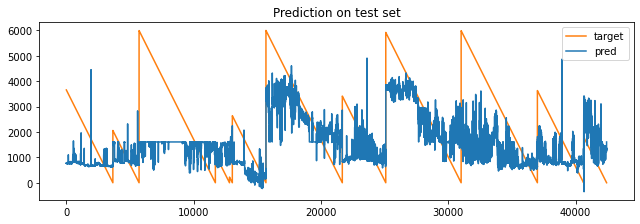

In [79]:
ts_pred4 = nn4.predict(ts_s[dt_in]).ravel()*tr_maxrul
cmapss.plot_rul(ts_pred4[:], ts.rul[:])
plt.title('Prediction on test set')

Optimal threshold: 840


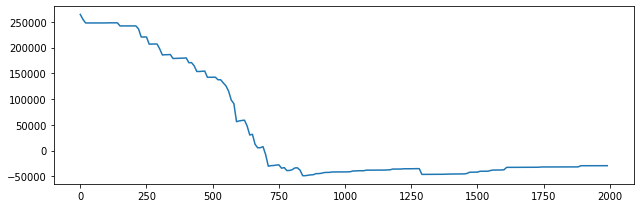

In [48]:
thr_range = np.arange(0, 2000, 10)
tr_thr4 = cmapss.opt_threshold_and_plot(tr.experiment.values, tr_pred4, thr_range, cmodel)
print(f'Optimal threshold: {tr_thr4}')

In [49]:
print_cfs(tr_pred4, ts_pred4, tr_thr4)

On training set:
Cost: -48699.0 	 Avg fails: 0.02 Avg slack: 1606.94

On test set:
Cost: -10667.0 	 Avg fails: 0.00 Avg slack: 2425.23


##Model 5: Negative Binomial Model

In [50]:
import tensorflow_probability as tfp
from tensorflow.keras import backend as k

def negbin_likelihood(y_true, y_pred):
    # y_true = RUL, y_pred = probability of going on
    dist = tfp.distributions.NegativeBinomial(total_count=1, logits=y_pred)
    return -k.sum(dist.log_prob(y_true))

def build_model5():
    model_in = layers.Input(shape=(len(dt_in),))
    x = layers.Dense(4, 'relu')(model_in)
    x = layers.Dropout(0.4, seed=0)(x)
    model_out = layers.Dense(1, 'linear')(x)
    return Model(model_in, model_out)

nn5 = build_model5()
nn5.compile(loss=negbin_likelihood, optimizer='adam')
nn5.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 59)]              0         
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 240       
_________________________________________________________________
dropout_8 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 5         
Total params: 245
Trainable params: 245
Non-trainable params: 0
_________________________________________________________________


In [51]:
history5 = []

for train, val in kfold.split(tr_s[dt_in], tr.rul):
    x_tr, y_tr = tr_s.loc[train, dt_in], tr.loc[train, 'rul']
    x_val, y_val = tr_s.loc[val, dt_in], tr.loc[val, 'rul']
    history = nn5.fit(x_tr, y_tr, validation_data=(x_val, y_val), epochs=5, callbacks=cb)
    history5.append(history)

Epoch 1/5
3468/3468 [==============================] - 6s 2ms/step - loss: 11313.4986 - val_loss: 642.9898
Epoch 2/5
3468/3468 [==============================] - 5s 2ms/step - loss: 1222.8408 - val_loss: 281.3405
Epoch 3/5
3468/3468 [==============================] - 5s 2ms/step - loss: 534.0468 - val_loss: 276.6694
Epoch 4/5
3468/3468 [==============================] - 5s 1ms/step - loss: 337.2605 - val_loss: 276.1393
Epoch 5/5
3468/3468 [==============================] - 5s 1ms/step - loss: 285.3030 - val_loss: 275.8662
Epoch 1/5
3468/3468 [==============================] - 5s 2ms/step - loss: 273.5751 - val_loss: 276.4913
Epoch 2/5
3468/3468 [==============================] - 6s 2ms/step - loss: 272.7973 - val_loss: 277.0187
Epoch 3/5
3468/3468 [==============================] - 6s 2ms/step - loss: 272.6661 - val_loss: 277.6394
Epoch 4/5
3468/3468 [==============================] - 5s 2ms/step - loss: 272.5852 - val_loss: 277.7400
Epoch 5/5
3468/3468 [==============================]

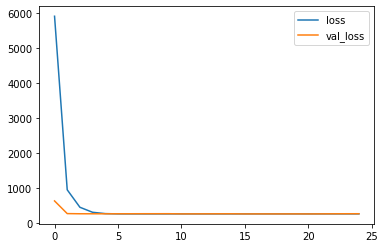

In [52]:
plot_kfold_history(history5)

In [53]:
ts_s.isna().any().any()

False

In [54]:
from scipy.special import expit
from scipy.stats import nbinom

tr_logits = nn5.predict(tr_s[dt_in]).ravel()
tr_p = expit(tr_logits)
tr_dist = nbinom(1, 1-tr_p)
tr_pred5 = tr_dist.mean()
tr_q1 = tr_dist.ppf(0.25)
tr_q3 = tr_dist.ppf(0.75)

ts_logits = nn5.predict(ts_s[dt_in]).ravel()
ts_p = expit(ts_logits)
ts_dist = nbinom(1, 1-ts_p)
ts_pred5 = ts_dist.mean()
ts_q1 = ts_dist.ppf(0.25)
ts_q3 = ts_dist.ppf(0.75)

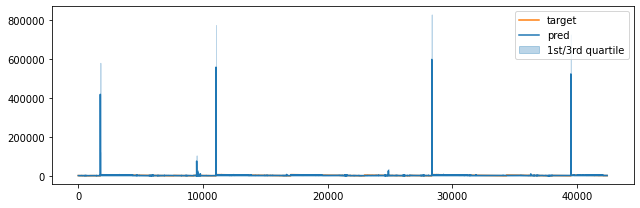

In [80]:
stop=len(ts)
cmapss.plot_rul(tr_pred5[:stop], tr.rul[:stop], q1_3=(tr_q1[:stop], tr_q3[:stop]))

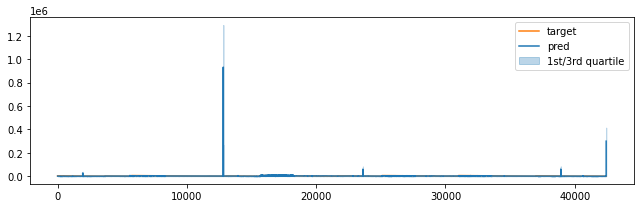

In [81]:
stop=20000
cmapss.plot_rul(ts_pred5[:], ts.rul[:], q1_3=(ts_q1[:], ts_q3[:]))

Optimal threshold: 455


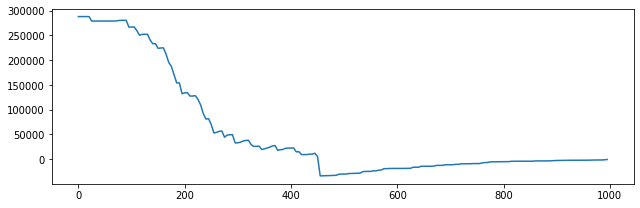

In [82]:
thr_range = np.arange(0, 1000, 5)
tr_thr5 = cmapss.opt_threshold_and_plot(tr.experiment.values, tr_q1, thr_range, cmodel)
print(f'Optimal threshold: {tr_thr5}')

In [83]:
print_cfs(tr_q1, ts_q1, tr_thr5)

On training set:
Cost: -33442.0 	 Avg fails: 0.00 Avg slack: 2179.08

On test set:
Cost: 1784.0 	 Avg fails: 0.15 Avg slack: 2007.00


## Model 6: Normal distribution

In [59]:
import tensorflow_probability as tfp
from tensorflow.keras import backend as k

def build_probabilistic_regressor():
    input_shape = (len(dt_in), )
    model_in = layers.Input(shape=input_shape)
    x = model_in
    x = layers.Dense(8, activation='relu')(x)
    x = layers.Dropout(0.4, seed=0)(x)
    mu_logsig = layers.Dense(2, activation='linear')(x)
    lf = lambda t: tfp.distributions.Normal(loc=t[:, :1], scale=k.exp(t[:, 1:]))
    model_out = tfp.layers.DistributionLambda(lf)(mu_logsig)
    model = Model(model_in, model_out)
    return model

def dlambda_likelihood(y_true, dist):
    return -dist.log_prob(y_true)

nn6 = build_probabilistic_regressor()
nn6.compile(optimizer='adam', loss=dlambda_likelihood)   


In [60]:
history6 = []

for train, val in kfold.split(tr_s[dt_in], tr_s.rul):
    x_tr, y_tr = tr_s.loc[train, dt_in], tr_s.loc[train, 'rul']
    x_val, y_val = tr_s.loc[val, dt_in], tr_s.loc[val, 'rul']
    history = nn6.fit(x_tr, y_tr, validation_data=(x_val, y_val), epochs=5, callbacks=cb)
    history6.append(history)

Epoch 1/5
3468/3468 [==============================] - 6s 2ms/step - loss: 1.4361 - val_loss: 0.4048
Epoch 2/5
3468/3468 [==============================] - 5s 2ms/step - loss: 0.1863 - val_loss: -0.1323
Epoch 3/5
3468/3468 [==============================] - 5s 1ms/step - loss: -0.2158 - val_loss: -0.1325
Epoch 4/5
3468/3468 [==============================] - 5s 2ms/step - loss: -0.3206 - val_loss: -0.2516
Epoch 5/5
3468/3468 [==============================] - 5s 1ms/step - loss: -0.2295 - val_loss: -0.1954
Epoch 1/5
3468/3468 [==============================] - 5s 2ms/step - loss: -0.3636 - val_loss: -0.2456
Epoch 2/5
3468/3468 [==============================] - 6s 2ms/step - loss: -0.3970 - val_loss: -0.1678
Epoch 3/5
3468/3468 [==============================] - 6s 2ms/step - loss: -0.4288 - val_loss: 0.0215
Epoch 4/5
3468/3468 [==============================] - 5s 2ms/step - loss: -0.4415 - val_loss: 0.2484
Epoch 5/5
3468/3468 [==============================] - 5s 1ms/step - loss: -0.

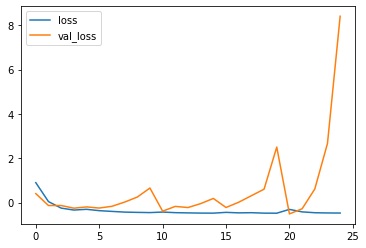

In [61]:
plot_kfold_history(history6)

In [62]:
tr_prob_pred = nn6(tr_s[dt_in].values)
tr_pred6 = tr_prob_pred.mean().numpy().ravel() * tr_maxrul
tr_std6 = tr_prob_pred.stddev().numpy().ravel() * tr_maxrul

ts_prob_pred = nn6(ts_s[dt_in].values)
ts_pred6 = ts_prob_pred.mean().numpy().ravel() * tr_maxrul
ts_std6 = ts_prob_pred.stddev().numpy().ravel() * tr_maxrul

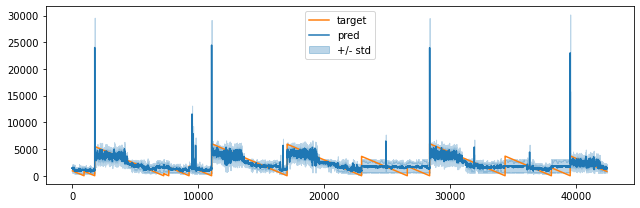

In [84]:
stop=len(ts)
cmapss.plot_rul(tr_pred6[:stop], tr['rul'][:stop], stddev=tr_std6[:stop])

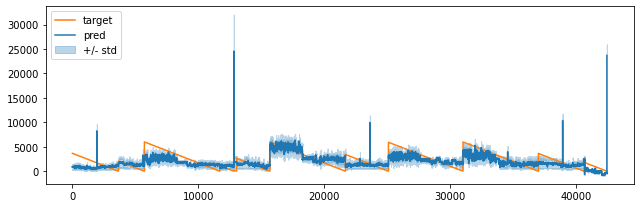

In [85]:
stop=12500
cmapss.plot_rul(ts_pred6[:], ts['rul'][:], stddev=ts_std6[:])

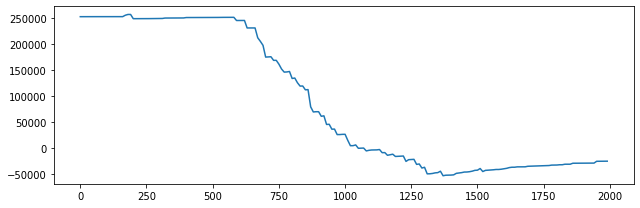

In [65]:
thr_range = np.arange(0,2000,10)
tr_thr6 = cmapss.opt_threshold_and_plot(tr.experiment.values, tr_pred6, thr_range, cmodel, plot=True)

In [66]:
print_cfs(tr_pred6, ts_pred6, tr_thr6)

On training set:
Cost: -53181.0 	 Avg fails: 0.02 Avg slack: 1605.04

On test set:
Cost: -5654.0 	 Avg fails: 0.08 Avg slack: 2347.23
